In [2]:
import os
import sys

import torch
from torch import nn, optim
from torch.nn import functional as FeatureAlphaDropout
import torch.nn as nn
sys.path.append(os.path.realpath('../'))
import numpy as np
import pickle as pkl
from datasets import make_dataloader
from bitrap.modeling import make_model
from bitrap.engine import build_engine

from bitrap.utils.logger import Logger
import logging
import argparse
from configs import cfg
from termcolor import colored 

from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


/home/waluigi/miniconda3/envs/pytorch38/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cfg.merge_from_file("../configs/bitrap_np_JAAD.yml")
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [5]:
model = make_model(cfg)
model = model.to(cfg.DEVICE)
checkpoint = "../" + cfg.CKPT_DIR + "best.pth"

if os.path.isfile(checkpoint):
    model.load_state_dict(torch.load(checkpoint))
    print(colored('Loaded checkpoint:{}'.format(checkpoint), 'blue', 'on_green'))
else:
    print(colored('The cfg.CKPT_DIR id not a file: {}'.format(checkpoint), 'green', 'on_red'))

Loaded checkpoint:../checkpoints/JAAD_checkpoints/goal_cvae_checkpoints/best.pth


In [6]:
_, _, inference = build_engine(cfg)

In [12]:
images = [f"../data/JAAD/images/video_0005/000{i + 46}.png" for i in range(15)]
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)


dataloader = DataLoader(images, num_workers=1)
print(len(images))

Using cache found in /home/waluigi/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-11-4 Python-3.10.6 torch-1.13.0 CUDA:0 (NVIDIA GeForce RTX 3090, 24246MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


15


In [43]:
def predict(model, input_x, cur_pos = None):
    gt_goal = None
    cur_pos = input_x[:, -1, :cfg.MODEL.DEC_OUTPUT_DIM] if cur_pos is None else cur_pos
    batch_size, seg_len, _ = input_x.shape

    h_x = model.encoder(input_x, None)
    Z, KLD = model.gaussian_latent_net(h_x, input_x[:, -1, :cfg.MODEL.DEC_OUTPUT_DIM], None, z_mode=False)
    enc_h_and_z = torch.cat([h_x.unsqueeze(1).repeat(1, Z.shape[1], 1), Z], dim=-1)
    pred_goal = model.goal_decoder(enc_h_and_z)
    # dec_h = enc_h_and_z if model.cfg.DEC_WITH_Z else h_x

    pred_goal = model.goal_decoder(enc_h_and_z)

    # dec_h = enc_h_and_z if model.cfg.DEC_WITH_Z else h_x
    pred_traj = model.pred_future_traj(h_x, pred_goal)
    cur_pos = input_x[:, -1, :cfg.MODEL.DEC_OUTPUT_DIM] if cur_pos is None else cur_pos.unsqueeze(1)
    pred_goal = pred_goal + cur_pos
    pred_traj = pred_traj + cur_pos.unsqueeze(1)

    return pred_traj, pred_goal



In [1]:
def get_image(imgs):
    results = yolo(imgs)
    data = []
    for j in range(len(results.pandas().xyxy)):
        df = results.pandas().xyxy[j]
        bounding_boxes_pedestrians = df.loc[df['class'] == 0]
        # TODO: FOR NOW, break statement exists so it only predicts one person... This will need to change
        for i, row in bounding_boxes_pedestrians.iterrows():
            data.append([row['xmin'], row['ymin'], row['xmax'], row['ymax']])
            break
    data = np.array(data)
    max_val = torch.abs(data).max()
    min_val = torch.tensor(data).min()

    data /= max_val


    return torch.FloatTensor(data), max_val, min_val


In [65]:
model.eval()

input_x, max_val, min_val = get_image(images).to(cfg.DEVICE)
input_x = input_x.unsqueeze(0)
cur_pos = input_x[:, -1, :cfg.MODEL.DEC_OUTPUT_DIM]
pred_traj, pred_goal = predict(model, input_x, cur_pos=input_x[-1, :cfg.MODEL.DEC_OUTPUT_DIM])
pred_traj = pred_traj.detach().to('cpu').numpy()
pred_goal = pred_goal.detach().to('cpu').numpy()


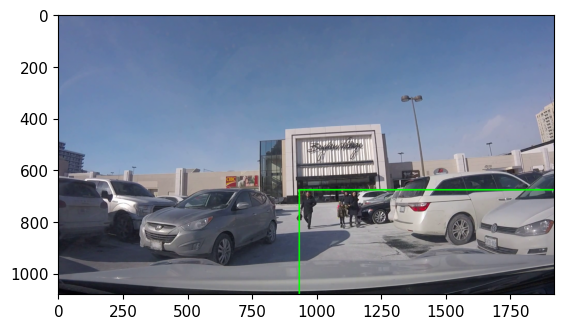

In [69]:
cv_image = cv2.imread(f"../data/JAAD/images/video_0005/00061.png")
for test in pred_traj:
    for traj in test:
        for box in traj:
            # rect = cv2.boundingRect(testArray)
            x, y, w, h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
            cv2.rectangle(cv_image, (x, y), (w, h), (0, 255, 0), 2)

RGB_img = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()